## **Importing libraries and datasets**

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_response = pd.read_csv('/content/drive/MyDrive/BADS7105 - CRM/Campaign Response Model/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/BADS7105 - CRM/Campaign Response Model/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


In [ ]:
df_response.nunique()

customer_id    6884
response          2
dtype: int64

In [ ]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [ ]:
df_transactions.nunique()

customer_id    6889
trans_date     1401
tran_amount      96
dtype: int64

In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [ ]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [ ]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [ ]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [ ]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [ ]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


In [ ]:
# Create additional feature

df_add = df_transactions.groupby('customer_id').agg(min_pur = ('tran_amount','min'),
                                                    max_pur = ('tran_amount','max'),
                                                    sd_pur = ('tran_amount','std')).reset_index()

df_add.head()

,customer_id,min_pur,max_pur,sd_pur
0,CS1112,36,105,19.766012
1,CS1113,36,98,21.254102
2,CS1114,37,105,21.341692
3,CS1115,41,104,18.151896
4,CS1116,40,105,22.940000


In [ ]:
# Create Mean Time Between Purchase

df_mtbp = df_transactions.sort_values(['customer_id', 'trans_date'])
df_mtbp.head()

,customer_id,trans_date,tran_amount,recent
77247,CS1112,2011-06-15,56,1371.0
89149,CS1112,2011-08-19,96,1306.0
68206,CS1112,2011-10-02,60,1262.0
36486,CS1112,2012-04-08,56,1073.0
93074,CS1112,2012-06-24,52,996.0


In [ ]:
df2 = df_mtbp.groupby("customer_id").apply(
    lambda df_mtbp: (df_mtbp.trans_date - df_mtbp.trans_date.shift(1)).dt.days).reset_index()

df2 = df2.rename(columns={'trans_date': 'time-between-purchase'})
df2.index = df2.level_1
df2.head()

,customer_id,level_1,time-between-purchase
level_1,,,
77247,CS1112,77247,NaN
89149,CS1112,89149,65.0
68206,CS1112,68206,44.0
36486,CS1112,36486,189.0
93074,CS1112,93074,77.0


In [ ]:
df_mtbp = df_mtbp.join(df2['time-between-purchase'])

In [ ]:
df_mtbp = df_mtbp.groupby("customer_id").agg(time_between_purchase=("time-between-purchase", "mean"),
                                            minimum_between_purchase=("time-between-purchase", "min"),
                                            maximum_between_purchase=("time-between-purchase", "max"),
                                            sd_between_purchase=("time-between-purchase", "std")).reset_index()


df_mtbp.head(20)

,customer_id,time_between_purchase,minimum_between_purchase,maximum_between_purchase,sd_between_purchase
0,CS1112,93.500000,9.0,189.0,50.873523
1,CS1113,71.263158,0.0,169.0,54.685812
2,CS1114,72.722222,1.0,237.0,73.693168
3,CS1115,62.047619,8.0,260.0,55.413425
4,CS1116,96.250000,9.0,399.0,107.361010
5,CS1117,71.187500,6.0,401.0,100.191296
6,CS1118,99.714286,5.0,332.0,96.863448
7,CS1119,78.642857,2.0,146.0,53.231869
8,CS1120,60.000000,2.0,347.0,82.902462
9,CS1121,53.800000,0.0,254.0,58.064619


In [ ]:
df_percentile = df_transactions.groupby('customer_id').agg(percentile_10_ticket=('tran_amount',lambda x: np.quantile(x, 0.10)),
                                                           percentile_90_ticket=('tran_amount',lambda x: np.quantile(x, 0.90)),
                                                           percentile_95_ticket=('tran_amount',lambda x: np.quantile(x, 0.95))).reset_index()


df_percentile.head(10)

,customer_id,percentile_10_ticket,percentile_90_ticket,percentile_95_ticket
0,CS1112,44.2,93.6,98.70
1,CS1113,43.6,97.0,97.05
2,CS1114,45.4,97.0,97.80
3,CS1115,50.5,97.7,101.80
4,CS1116,41.6,94.8,99.60
5,CS1117,47.8,95.6,98.40
6,CS1118,44.2,96.0,98.90
7,CS1119,41.2,99.6,100.60
8,CS1120,46.0,99.4,100.85
9,CS1121,38.0,92.5,100.75


## **Calculating response rate**

In [ ]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


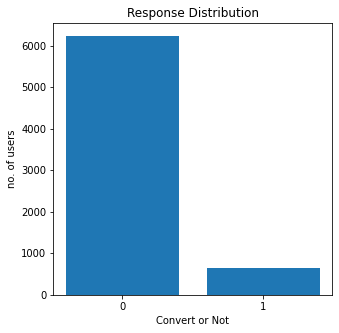

In [ ]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [ ]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [ ]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


In [ ]:
## merging two data sets - MTBP

df_modeling_clv_mtbp = pd.merge(df_modeling_clv, df_mtbp)
df_modeling_clv_mtbp = pd.merge(df_modeling_clv_mtbp, df_add)
df_modeling_clv_mtbp = pd.merge(df_modeling_clv_mtbp, df_percentile)
df_modeling_clv_mtbp.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size,time_between_purchase,minimum_between_purchase,maximum_between_purchase,sd_between_purchase,min_pur,max_pur,sd_pur,percentile_10_ticket,percentile_90_ticket,percentile_95_ticket
0,CS1112,0,62.0,15,1012,1309,67.466667,93.500000,9.0,189.0,50.873523,36,105,19.766012,44.2,93.6,98.70
1,CS1113,0,36.0,20,1490,1354,74.500000,71.263158,0.0,169.0,54.685812,36,98,21.254102,43.6,97.0,97.05
2,CS1114,1,33.0,19,1432,1309,75.368421,72.722222,1.0,237.0,73.693168,37,105,21.341692,45.4,97.0,97.80
3,CS1115,1,12.0,22,1659,1303,75.409091,62.047619,8.0,260.0,55.413425,41,104,18.151896,50.5,97.7,101.80
4,CS1116,1,204.0,13,857,1155,65.923077,96.250000,9.0,399.0,107.361010,40,105,22.940000,41.6,94.8,99.60


In [ ]:
df_modeling_clv_mtbp.columns

Index(['customer_id', 'response', 'recency', 'frequency', 'monetary_value',
       'AOU', 'ticket_size', 'time_between_purchase',
       'minimum_between_purchase', 'maximum_between_purchase',
       'sd_between_purchase', 'min_pur', 'max_pur', 'sd_pur',
       'percentile_5_ticket', 'percentile_10_ticket', 'percentile_90_ticket',
       'percentile_95_ticket'],
      dtype='object')

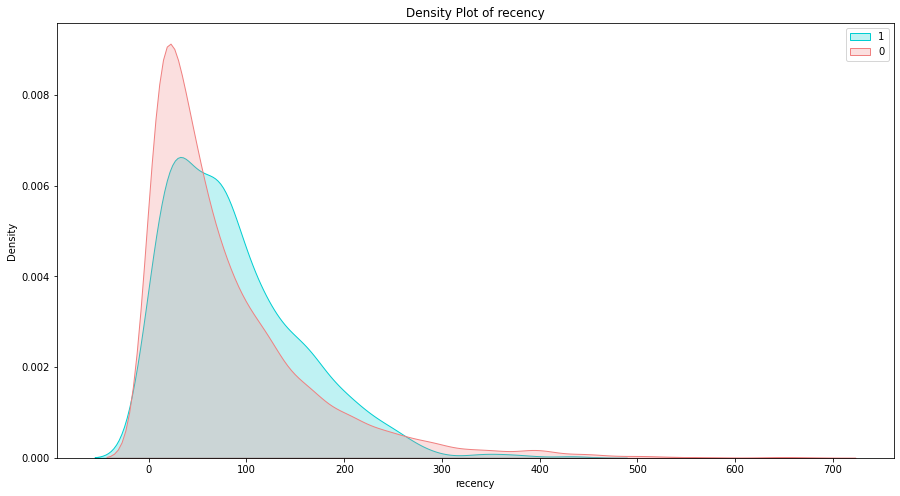

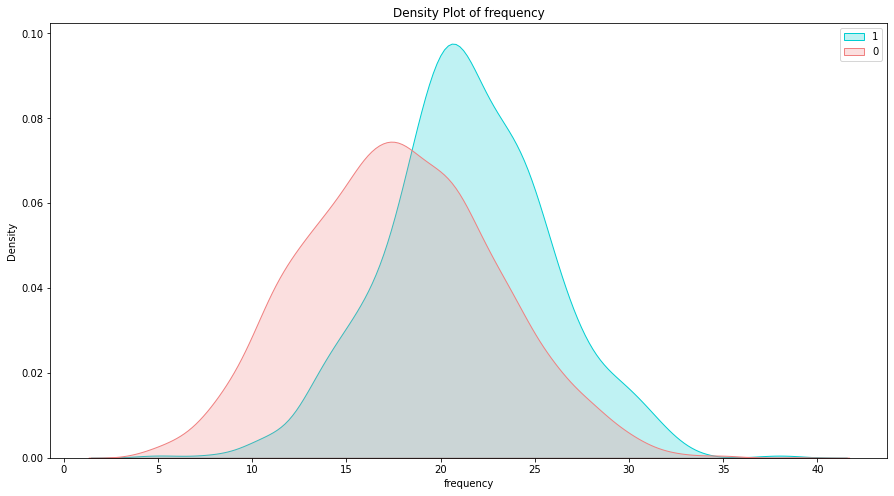

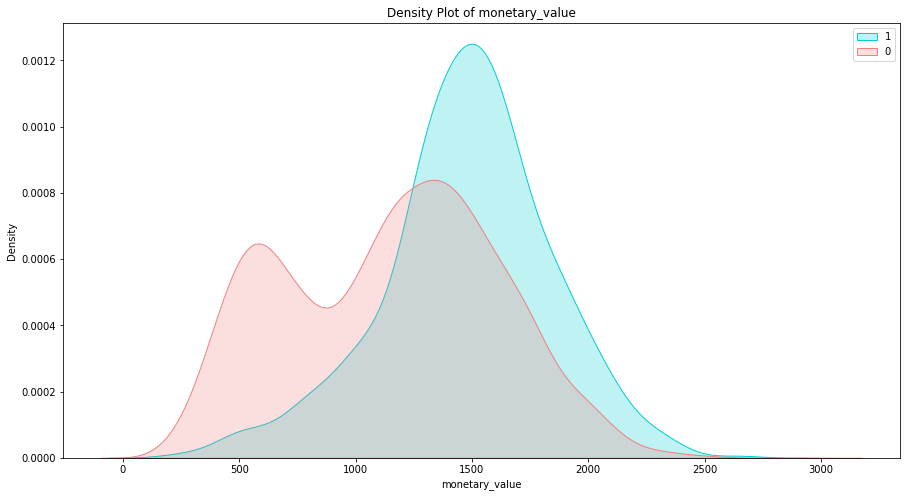

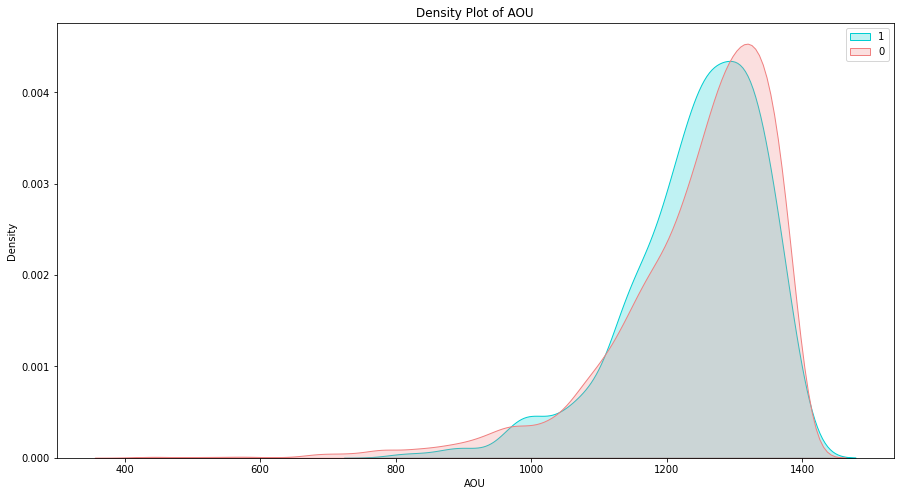

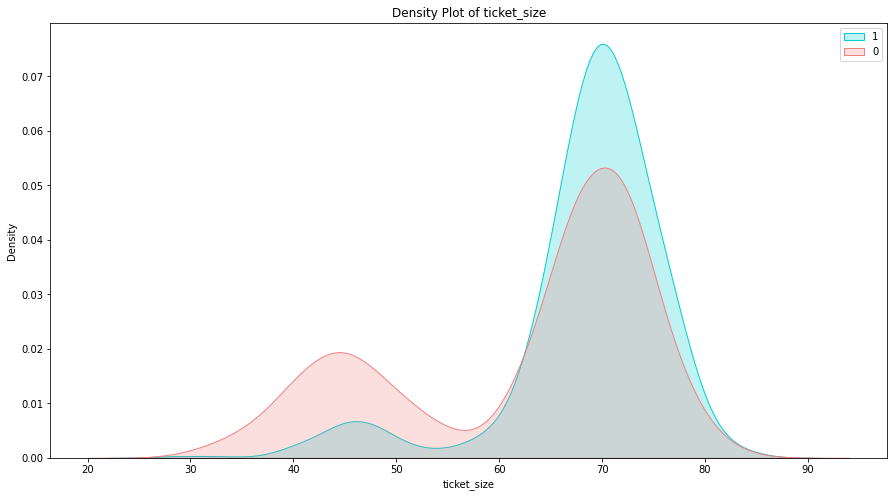

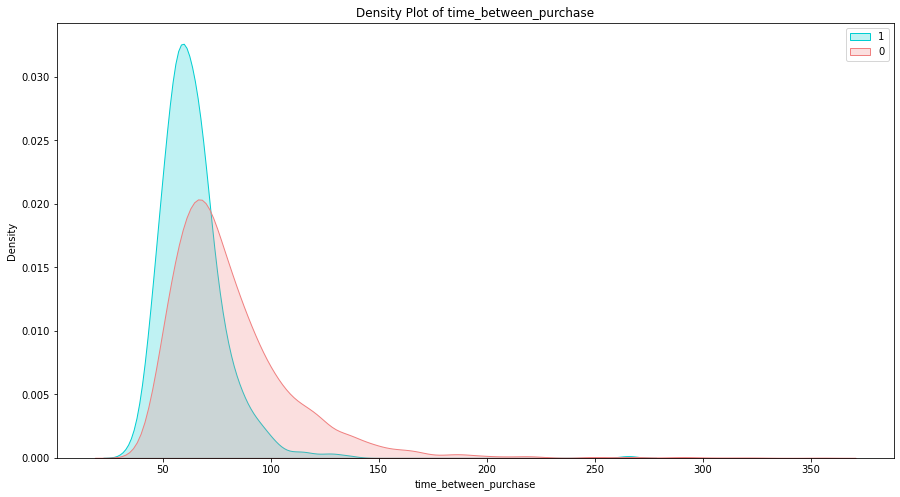

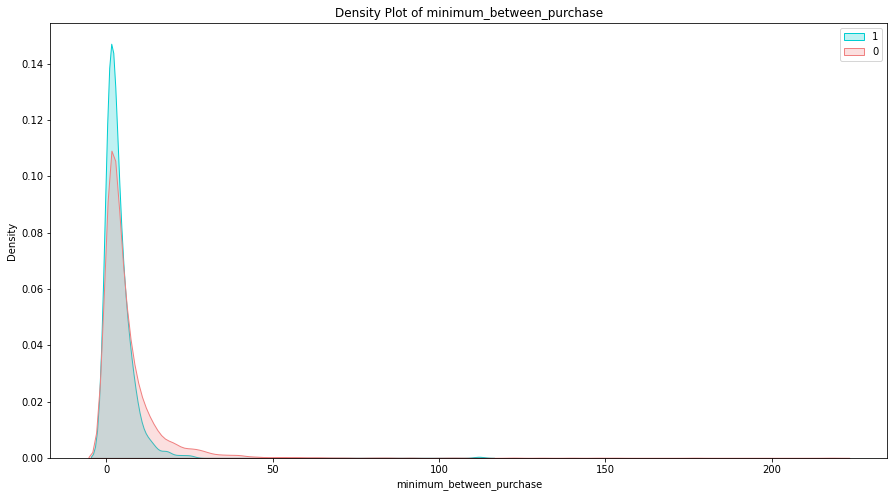

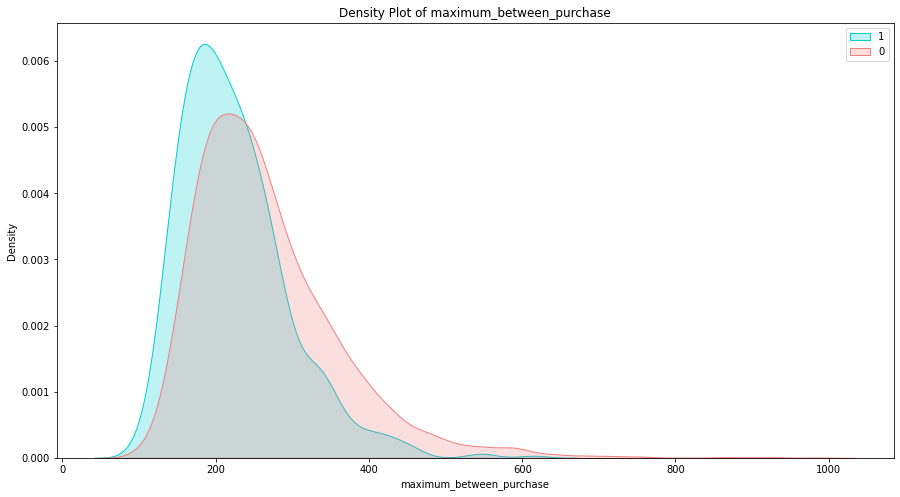

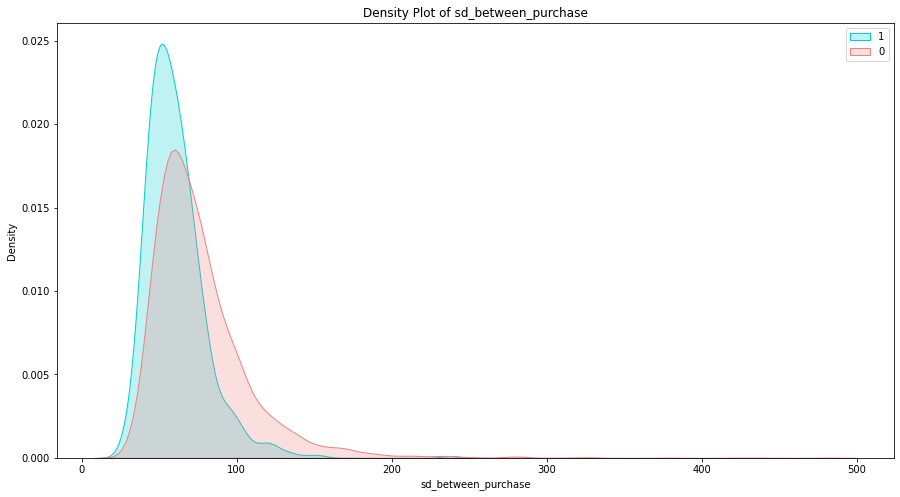

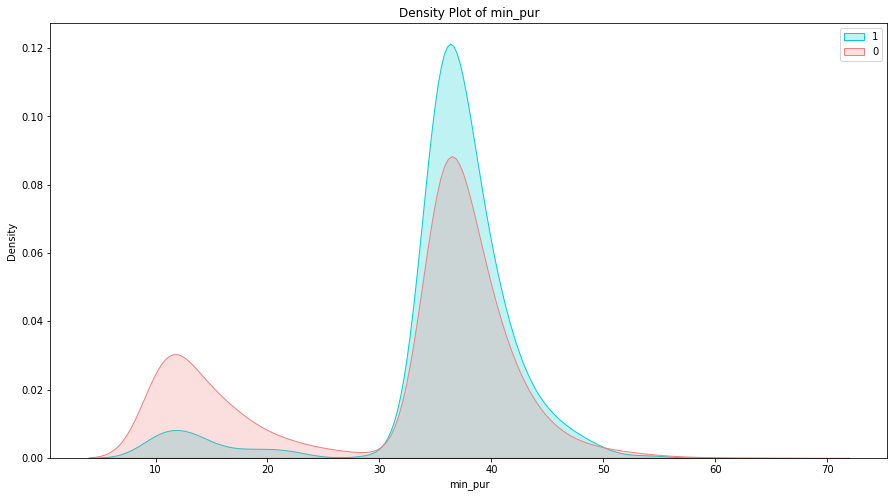

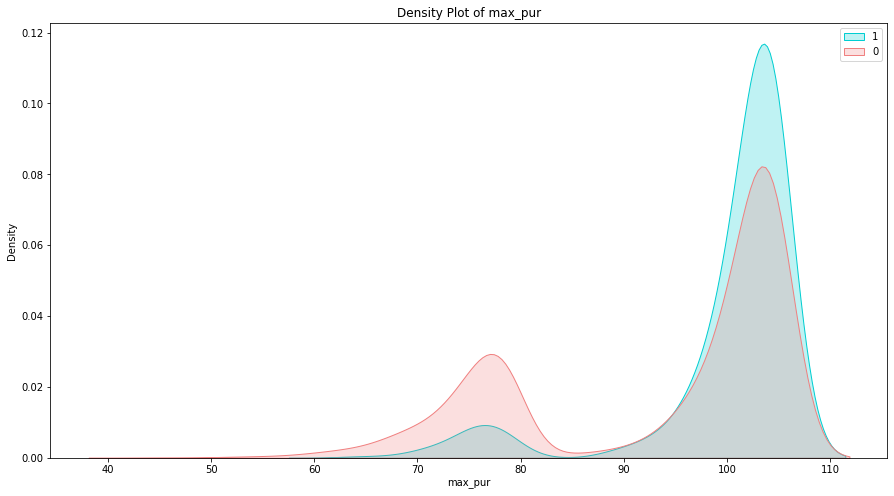

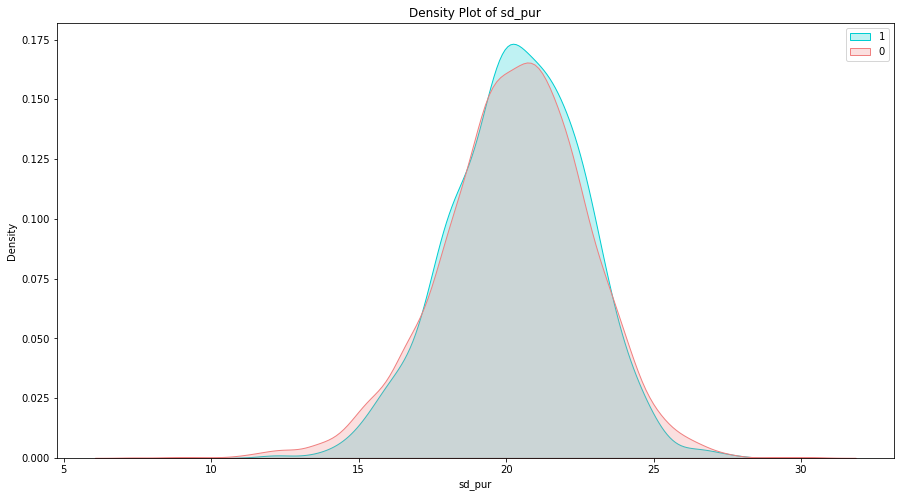

In [ ]:
for col in df_modeling_clv_mtbp[['recency', 'frequency', 'monetary_value',
                                   'AOU', 'ticket_size', 'time_between_purchase',
                                   'minimum_between_purchase', 'maximum_between_purchase',
                                   'sd_between_purchase', 'min_pur', 'max_pur', 'sd_pur']].columns:
    plt.figure(figsize=(15,8))
    ax = sns.kdeplot(df_modeling_clv_mtbp[col][df_modeling_clv_mtbp['response'] == 1], color="darkturquoise", shade=True)
    sns.kdeplot(df_modeling_clv_mtbp[col][df_modeling_clv_mtbp['response'] == 0], color="lightcoral", shade=True)
    plt.legend(['1', '0'])
    plt.title(f'Density Plot of {col}')
    ax.set(xlabel=col)
    #plt.xlim(0,5.5)
    plt.show()

## **Creating train and test dataset**

In [ ]:
df_modeling_clv_mtbp.columns

Index(['customer_id', 'response', 'recency', 'frequency', 'monetary_value',
       'AOU', 'ticket_size', 'time_between_purchase',
       'minimum_between_purchase', 'maximum_between_purchase',
       'sd_between_purchase', 'min_pur', 'max_pur', 'sd_pur'],
      dtype='object')

In [ ]:
# select columns --> 'recency', 'frequency', 'monetary_value', , 'ticket_size' 'time_between_purchase', 'min_pur', 'max_pur'

In [ ]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

X_clv_mtbp = df_modeling_clv_mtbp.drop(columns=['response','customer_id', 'AOU', 'minimum_between_purchase', 'maximum_between_purchase',
       'sd_between_purchase', 'sd_pur'])
y_clv_mtbp = df_modeling_clv_mtbp['response']

In [ ]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm.values, y_rfm.values, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv.values, y_clv.values, test_size=0.3, random_state=0)
X_train_clv_mtbp, X_test_clv_mtbp, y_train_clv_mtbp, y_test_clv_mtbp = train_test_split(X_clv_mtbp.values, y_clv_mtbp.values, test_size=0.3, random_state=0)

In [ ]:
df_modeling_clv_mtbp.columns

Index(['customer_id', 'response', 'recency', 'frequency', 'monetary_value',
       'AOU', 'ticket_size', 'time_between_purchase',
       'minimum_between_purchase', 'maximum_between_purchase',
       'sd_between_purchase', 'min_pur', 'max_pur', 'sd_pur'],
      dtype='object')

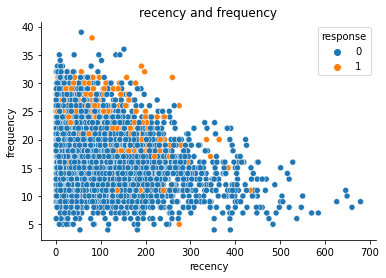

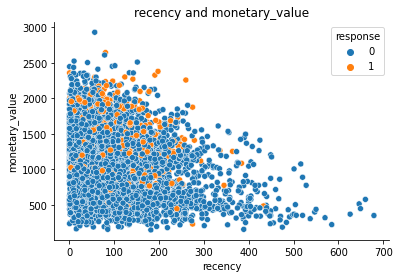

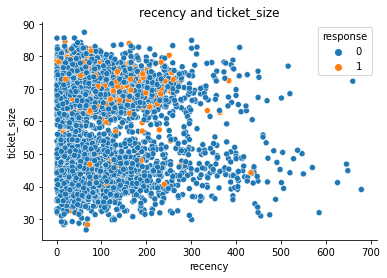

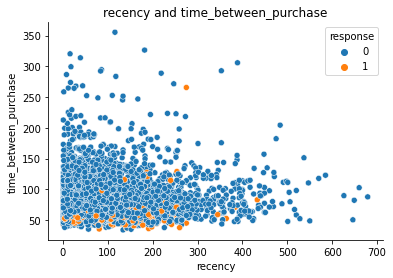

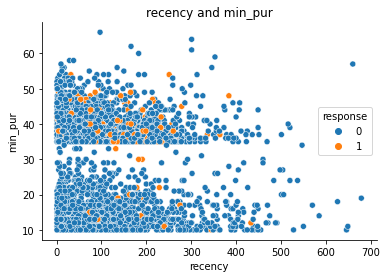

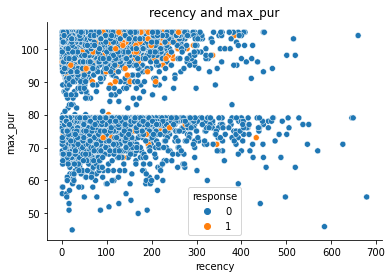

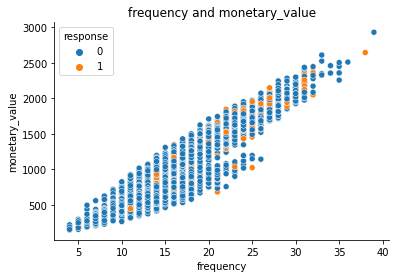

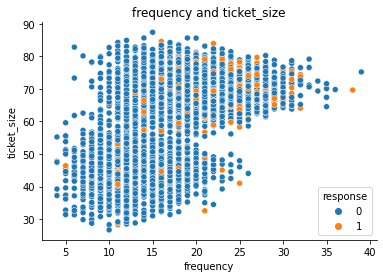

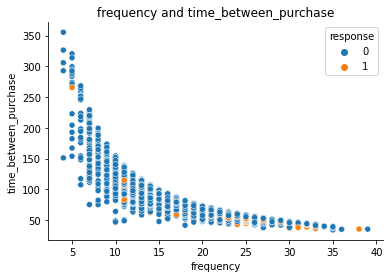

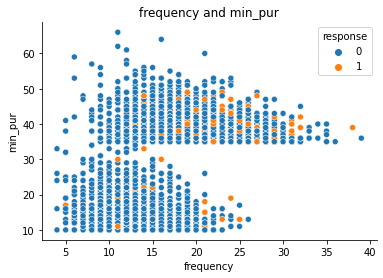

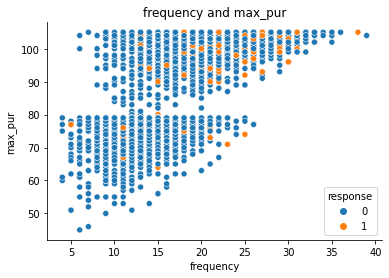

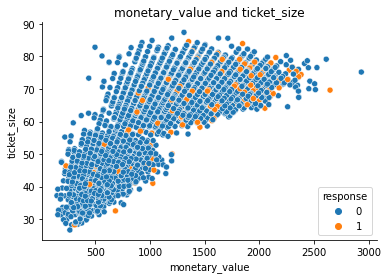

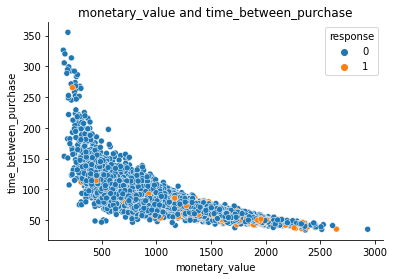

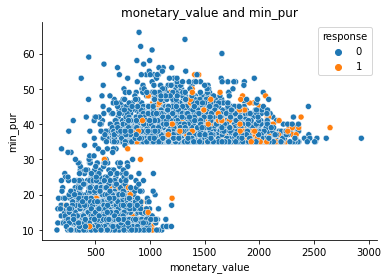

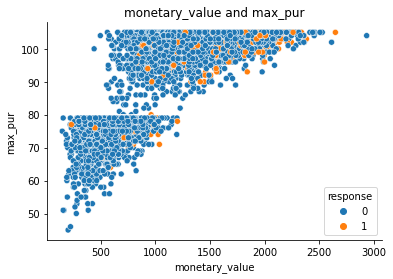

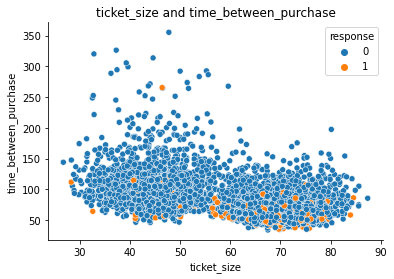

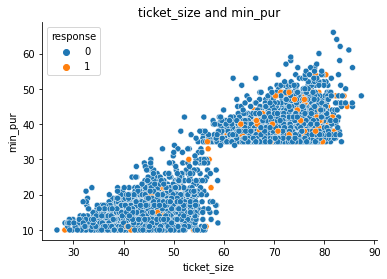

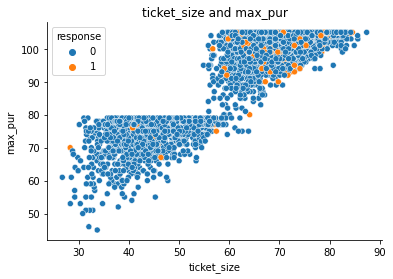

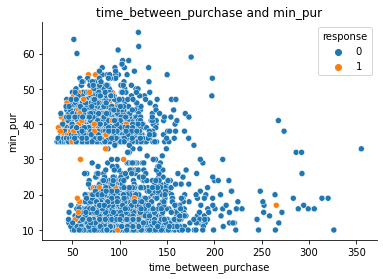

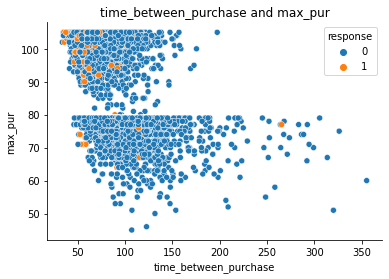

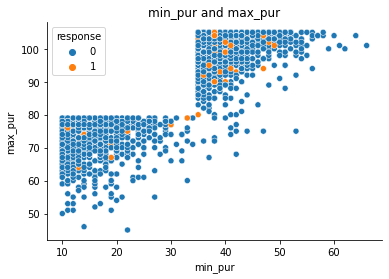

In [ ]:
# select columns --> 'recency', 'frequency', 'monetary_value', 'ticket_size', 'time_between_purchase', 'min_pur', 'max_pur'

for i, col_i in enumerate(df_modeling_clv_mtbp[['recency', 'frequency', 'monetary_value', 'ticket_size', 'time_between_purchase', 'min_pur', 'max_pur']].columns):
    for j, col_j in enumerate(df_modeling_clv_mtbp[['recency', 'frequency', 'monetary_value' , 'ticket_size', 'time_between_purchase', 'min_pur', 'max_pur']].columns):
        if i < j :
            plt.title(col_i + ' and ' + col_j)
            sns.scatterplot(data=df_modeling_clv_mtbp, x=col_i, y=col_j, hue='response')
            sns.despine()
            plt.show()

## **Fixing imbalanced with SMOTE**

In [ ]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

sm.fit(X_train_clv_mtbp, y_train_clv_mtbp)
X_SMOTE_clv_mtbp, y_SMOTE_clv_mtbp = sm.fit_resample(X_train_clv_mtbp, y_train_clv_mtbp)

## **Logistic Regression**

In [ ]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1848
           1       0.18      0.71      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.64      0.71      2066



In [ ]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1848
           1       0.18      0.72      0.29       218

    accuracy                           0.63      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.63      0.70      2066



In [ ]:
print('logistic regression model - SMOTE CLV_mtbp')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv_mtbp = logreg.fit(X_SMOTE_clv_mtbp, y_SMOTE_clv_mtbp)
predictions = logreg_model_SMOTE_clv_mtbp.predict(X_SMOTE_clv_mtbp)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv_mtbp)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)
train_auc = roc_auc_score(expected_y, predicted_y)


predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv_mtbp.predict(X_test_clv_mtbp)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv_mtbp)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

# AUC Score
print('=== AUC Score ===')
test_auc = roc_auc_score(expected_y, predicted_y)
print(f'train set: {train_auc}')
print(f'test set: {test_auc}')

logistic regression model - SMOTE CLV_mtbp
training set
              precision    recall  f1-score   support

           0       0.70      0.57      0.63      4389
           1       0.64      0.76      0.69      4389

    accuracy                           0.66      8778
   macro avg       0.67      0.66      0.66      8778
weighted avg       0.67      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.56      0.71      1848
           1       0.18      0.81      0.29       218

    accuracy                           0.59      2066
   macro avg       0.57      0.69      0.50      2066
weighted avg       0.88      0.59      0.67      2066

=== AUC Score ===
train set: 0.6639325586694007
test set: 0.6878897096787004


## **XGBoost**

In [ ]:
print('XGBoost model - SMOTE CLV_mtbp')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv_mtbp = xgb_model.fit(X_SMOTE_clv_mtbp, y_SMOTE_clv_mtbp, early_stopping_rounds=5, eval_set=[(X_test_clv_mtbp, y_test_clv_mtbp)])
predictions =  xgb_model_SMOTE_clv_mtbp.predict(X_SMOTE_clv_mtbp)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv_mtbp)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train)

# AUC Score
train_auc = roc_auc_score(expected_y, predicted_y)


predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv_mtbp.predict(X_test_clv_mtbp)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv_mtbp)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

# AUC Score
print('=== AUC Score ===')
test_auc = roc_auc_score(expected_y, predicted_y)
print(f'train set: {train_auc}')
print(f'test set: {test_auc}')

XGBoost model - SMOTE CLV_mtbp
[0]	validation_0-auc:0.681371
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.682653
[2]	validation_0-auc:0.681008
[3]	validation_0-auc:0.682653
[4]	validation_0-auc:0.681008
[5]	validation_0-auc:0.688238
[6]	validation_0-auc:0.693797
[7]	validation_0-auc:0.693986
[8]	validation_0-auc:0.694147
[9]	validation_0-auc:0.69244
[10]	validation_0-auc:0.693199
[11]	validation_0-auc:0.692464
[12]	validation_0-auc:0.69407
[13]	validation_0-auc:0.696748
[14]	validation_0-auc:0.705212
[15]	validation_0-auc:0.705192
[16]	validation_0-auc:0.70576
[17]	validation_0-auc:0.706061
[18]	validation_0-auc:0.706349
[19]	validation_0-auc:0.706039
[20]	validation_0-auc:0.706411
[21]	validation_0-auc:0.705756
[22]	validation_0-auc:0.70712
[23]	validation_0-auc:0.707075
[24]	validation_0-auc:0.70707
[25]	validation_0-auc:0.708214
[26]	validation_0-auc:0.708393
[27]	validation_0-auc:0.708045
[28]	validation_0-auc:0.707963
[29]	validation_0-auc:

In [ ]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [ ]:
## hyper parameter tuning - grid search - MTBP

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 6),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_mtbp_GS = grid.fit(X_train_clv_mtbp, y_train_clv_mtbp)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_mtbp_GS.predict(X_test_clv_mtbp)
print('Best AUC Score: {}'.format(xgb_model_clv_mtbp_GS.best_score_))
print(confusion_matrix(y_test_clv_mtbp,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv_mtbp)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

# AUC Score
print('=== AUC Score ===')
test_auc = roc_auc_score(expected_y, predicted_y)
print(f'train set: {train_auc}')
print(f'test set: {test_auc}')

Best AUC Score: 0.7128546168031679
[[1076  772]
 [  52  166]]
test set
              precision    recall  f1-score   support

           0       0.95      0.58      0.72      1848
           1       0.18      0.76      0.29       218

    accuracy                           0.60      2066
   macro avg       0.57      0.67      0.51      2066
weighted avg       0.87      0.60      0.68      2066

=== AUC Score ===
train set: 0.6953748006379585
test set: 0.6718594860796696


In [ ]:
print(xgb_model_clv_mtbp_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x000001A284163160>}
